100%|██████████| 1/1 [00:00<00:00, 18.39it/s]

Size: 0.2555904 GB
(128, 256, 1300, 6)


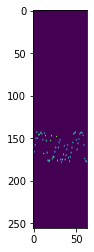

In [6]:
import os, random, multiprocessing

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import scipy.stats as sts

pd.options.mode.chained_assignment = None


def gaussian(x, mu, sig):
    val = np.asarray(
        np.exp(-np.power(x - mu, 2.0) / (2 * np.power(sig, 2.0))) * 100, dtype=np.int8
    )
    return val


class get_datacube:
    """ """

    def __init__(self):

        DATADIR = "data"
        LCFILE = os.path.join(DATADIR, "plasticc_train_lightcurves.csv.gz")
        LCS = pd.read_csv(LCFILE).set_index(["object_id"])

        ids = LCS.index.unique().values

        NBIN_X = 1300
        NBIN_Y = 256

        NBAND = 6

        start_mod = 59580.0343
        end_mod = 60674.363
        binned_mod, binned_mod_step = np.linspace(
            start_mod, end_mod, NBIN_X, retstep=True
        )

        final_cube = np.zeros((len(ids[:128]), NBIN_Y, NBIN_X, NBAND), dtype=np.int8)

        for i, object_id in enumerate(tqdm(ids[:1])):

            # multi-color light curve
            lc_full = LCS.query("object_id == @object_id")

            min_flux = lc_full.flux.min()
            peak_flux = lc_full.flux.max()

            # discretize flux column
            y_val, y_step = np.linspace(min_flux, peak_flux, NBIN_Y, retstep=True)

            # grid (3D cube)
            grid_full = np.zeros((NBIN_Y, NBIN_X, NBAND), dtype=np.float16)

            # loop over passband (color filters)
            for passband in range(1):

                # single-color light curve
                lc = lc_full.query("passband == @passband")

                # discretize flux column
                # Return the indices of the bins to which each value in input array belongs.
                y_select = np.digitize(
                    lc.flux, y_val, right=True
                )  # right=True: bins[i-1] < x <= bins[i]

                # normalized gaussian
                flux_grey_val = np.zeros((NBIN_Y, len(lc)))

                for point, (mu, sig, y_idx) in enumerate(
                    zip(lc.flux.values, lc.flux_err.values, y_select)
                ):
                    mu_pix = y_val[y_idx]  # - y_step/2
                    flux_grey_val[:, point] = gaussian(y_val, mu_pix, sig)

                # discretize mjd column
                x_select = np.digitize(lc.mjd.values, binned_mod, right=True)

                grid_full[:, x_select, passband] = flux_grey_val
                plt.imshow(flux_grey_val)

            final_cube[i] = grid_full

            del grid_full

        self.return_cube = final_cube


if __name__ == "__main__":

    cube = get_datacube()
    lcs = cube.return_cube
    print(f"Size: {lcs.nbytes / 1e9} GB")
    print(lcs.shape)

    # np.savez("augmented_data/pixelized_sample.npz", lcs)
